In [80]:
# Code to generate Figures 4f and 4g

In [81]:
import os
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
from hsi_detect.spectrum import Spectrum
from hsi_detect.image import HyperspectralImage
from hsi_detect.classifier import HierarchicalKMeansUnmixer
from hsi_detect.utils import *
from datetime import date

today = date.today()
date_str = today.strftime('%d%b%Y')
print ('Date prefix:', date_str)

# Plotting parameters
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['axes.linewidth']= 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 7

Date prefix: 09Apr2025


In [82]:
IMAGE_PATH = '/Users/Itai/Desktop/172/results/REFLECTANCE_172.hdr'
# CONC_MAP_PATH = 'plots_concentrations.csv'
REFERENCE_SPECTRUM_PATH = '../../from_box/Grad/research/bioHSI/04_image_processing/00_data/absorbance_data/YF10_infered_absorbance_from_pellets_09Jul2024.npy'

## DEFAULT SAVE PATH
savedir = '/'.join(IMAGE_PATH.split('/')[:-1])+f'{IMAGE_PATH.split("/")[-1].split(".hdr")[0]}_outputs_from_analysis/'

print (savedir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)
    print ('Made directory:', savedir)

/Users/Itai/Desktop/172/resultsREFLECTANCE_172_outputs_from_analysis/


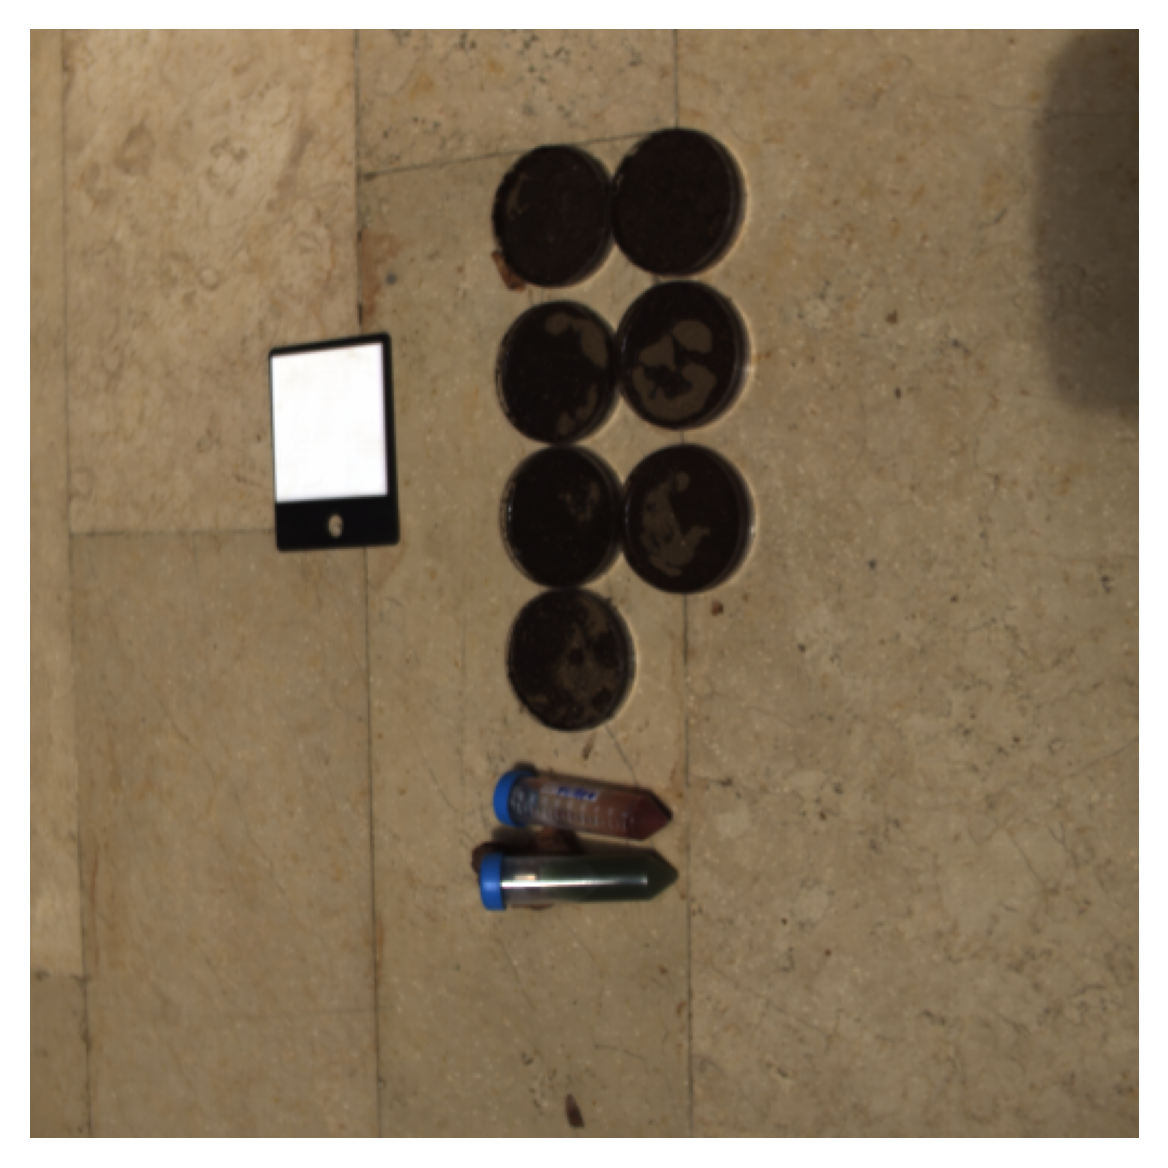

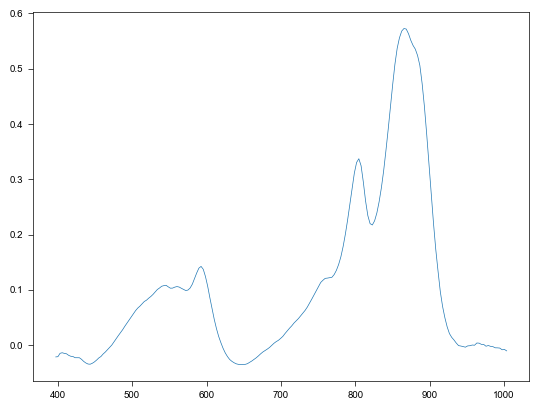

In [83]:
# Load and visualize image
hsi_img = HyperspectralImage(IMAGE_PATH, smoothing_window=11)
hsi_img.show(dpi=300, savepath=savedir+f'{date_str}_reconstructed_RGB.png')

# # Load and visualize the spectrum of the HSR
# reference_spectrum = Spectrum('../../from_box/Grad/research/bioHSI/04_image_processing/00_data/absorbance_data/YF10_infered_absorbance_from_pellets_09Jul2024.npy')
# reference_spectrum.interpolate_spectrum(hsi_img.centers) #Interpolate spectrum to fit the HSI
# reference_spectrum.show()

In [88]:
(255*hsi_img.rgb).astype(np.uint8)

(512, 512, 4)

In [97]:
px.imshow((np.reshape(hsi_img.rgb, hsi_img.rgb.shape[:3])).astype(np.uint8))

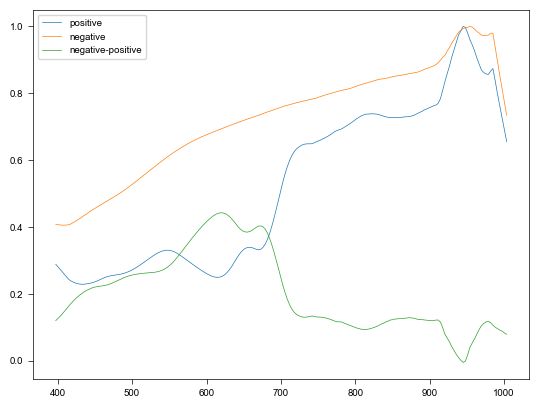

In [109]:


positive = hsi_img.image[382:388, 244:254]
negative = hsi_img.image[372:388, 335:360]
positive =  np.nanmean(positive, axis=(0,1))
negative = np.nanmean(negative, axis=(0,1))

positive = positive/np.nanmax(positive)#positive[get_closest_wl_ind(hsi_img.centers, 800)]
negative = negative/np.nanmax(negative)#negative[get_closest_wl_ind(hsi_img.centers, 800)]

plt.plot(hsi_img.centers, positive, label='positive')
plt.plot(hsi_img.centers, negative, label='negative')
plt.plot(hsi_img.centers, negative-positive, label='negative-positive')
plt.legend()
plt.show()


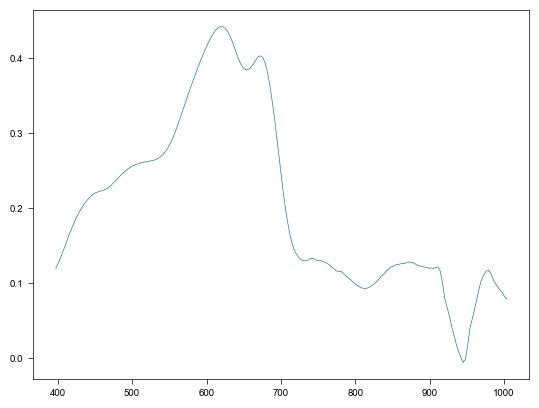

In [111]:
np.save('cyano_reference_spectrum.npy', np.stack([hsi_img.centers, negative-positive]))


reference_spectrum = Spectrum('cyano_reference_spectrum.npy')
reference_spectrum.interpolate_spectrum(hsi_img.centers) #Interpolate spectrum to fit the HSI
reference_spectrum.show()

In [116]:
hsi_classifier = HierarchicalKMeansUnmixer(filter_threshold=0.95, normalize=True)
hsi_classifier.fit(hsi_img, reference_spectrum)
scored_img = hsi_classifier.classify(reference_spectrum)

/Users/Itai/opt/anaconda3/envs/spectral/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Before filtering: 1000 endmembers
After filtering: 478 endmembers


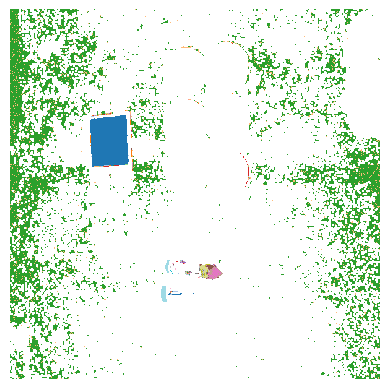

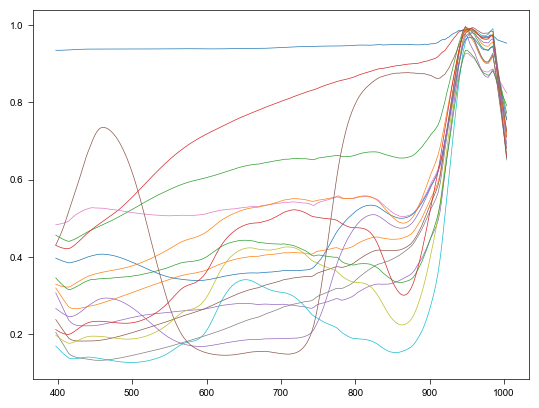

In [117]:
# The clustering results can be inspected
hsi_classifier.visualize_clusters()
hsi_classifier.visualize_endmembers()

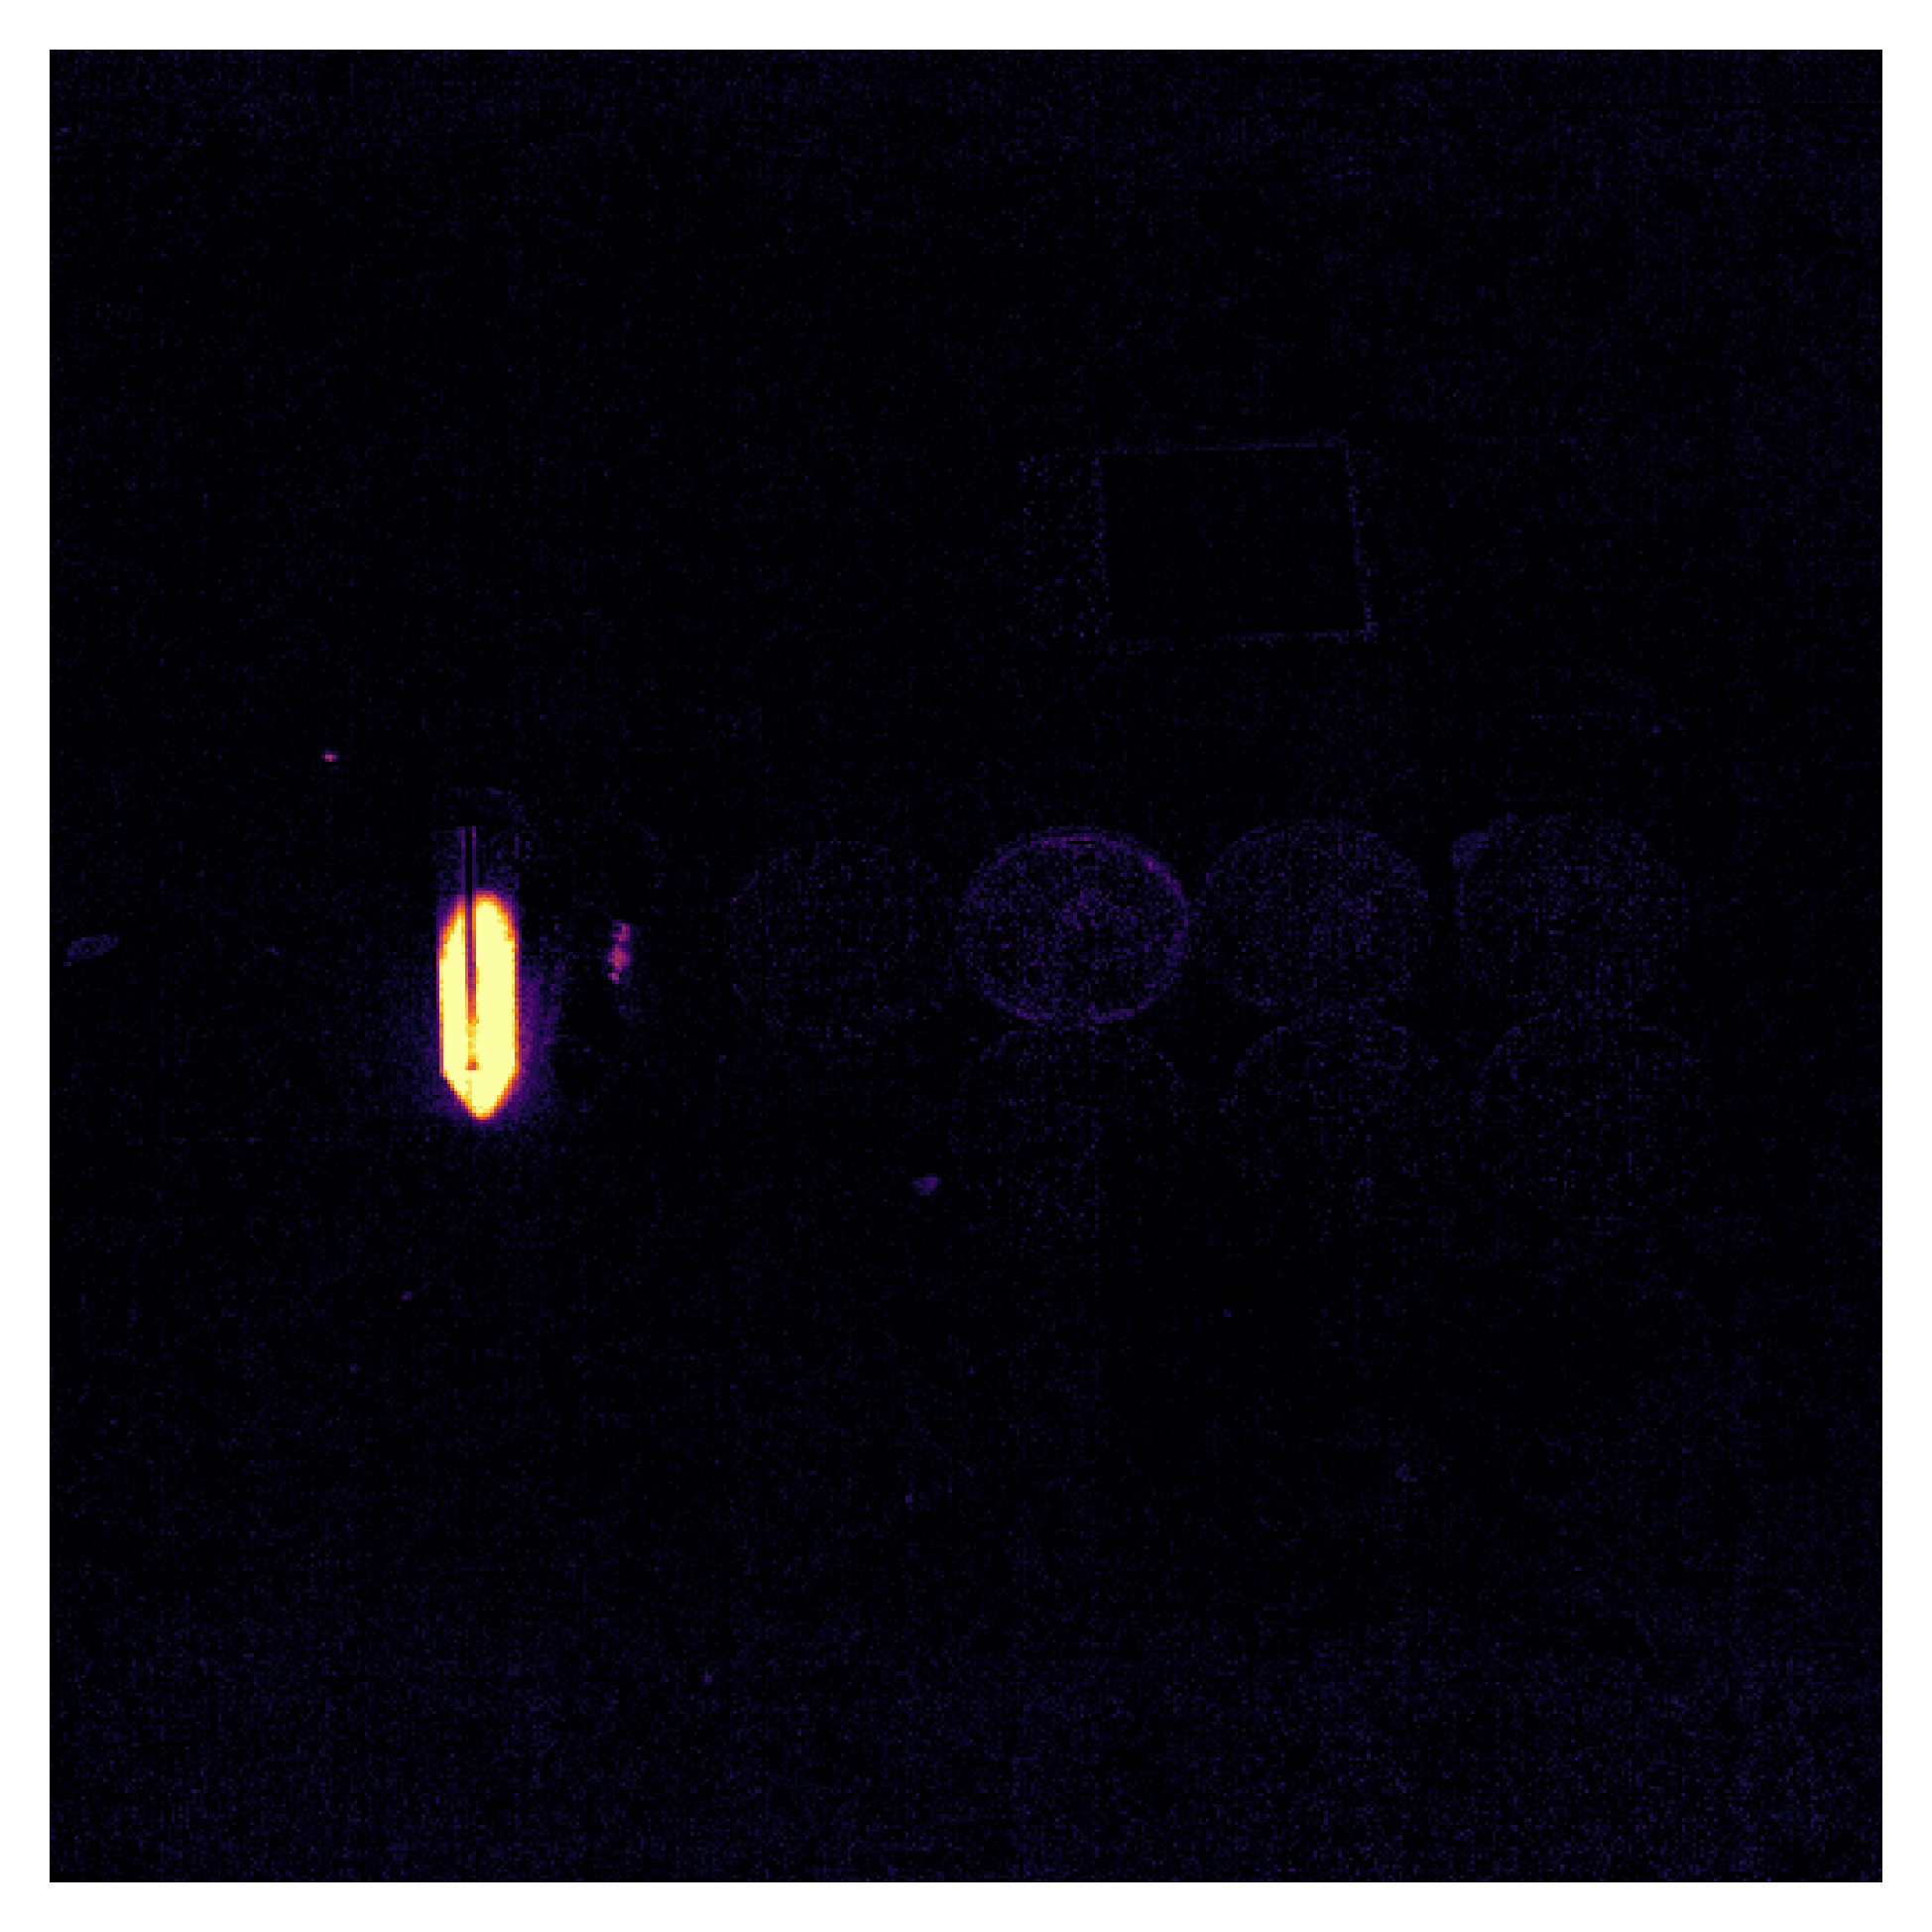

In [119]:
# Visualize classified image
plt.figure(dpi=500)
plt.imshow(np.rot90(scored_img, k=-1), vmin=0, vmax=1, cmap='inferno')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.show()

### Define areas where HSR is present for analysis

In [145]:
import json
if os.path.exists(f'{savedir}/manually_defined_rectangle_coordinates.json'):
    with open(f'{savedir}/manually_defined_rectangle_coordinates.json', 'r') as f:
        coords = json.load(f)
        rectangle_tls = coords['TL']
        rectangle_brs = coords['BR']
    print ('Loaded!')


In [ ]:
import numpy as np

RUNNING_LOCALLY = True # Set true if running on your own machine

### Interactive code to define the coordinates of circles of interest

# Style variables
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'borderRadius': '5px',
        'padding': '10px',
        'width': '100%',
        'color': '#333',
        'backgroundColor': '#f8f9fa'
    },
    'container': {
        'margin': '20px',
        'fontFamily': 'Arial, sans-serif'
    },
    'title': {
        'textAlign': 'center',
        'color': '#2c3e50',
        'marginBottom': '20px'
    },
    'panel': {
        'width': '30%', 
        'display': 'inline-block', 
        'verticalAlign': 'top', 
        'overflowY': 'auto', 
        'maxHeight': '500px',
        'padding': '15px',
        'backgroundColor': '#ffffff',
        'boxShadow': '0 4px 6px rgba(0, 0, 0, 0.1)',
        'borderRadius': '8px',
        'margin': '0 10px'
    },
    'graph': {
        'width': '65%', 
        'display': 'inline-block',
        'boxShadow': '0 4px 6px rgba(0, 0, 0, 0.1)',
        'borderRadius': '8px',
        'backgroundColor': '#ffffff'
    },
    'header': {
        'color': '#3498db',
        'borderBottom': '2px solid #3498db',
        'paddingBottom': '5px',
        'marginBottom': '10px'
    },
    'instruction': {
        'backgroundColor': '#e8f4f8',
        'padding': '10px',
        'borderRadius': '5px',
        'marginBottom': '15px',
        'fontSize': '14px'
    }
}
cmap = plt.get_cmap('tab20')

if not os.path.exists(f'{savedir}/manually_defined_circle_coordinates.json'): # Check if coordinates already exist
    from dash import Dash, dcc, html, Input, Output, callback
    #initialize
    circle_centers = []
    circle_radii = []
    count = 0
    selected = []
    im_id = 0
    ls = []
    rgb = hsi_img.rgb.astype(np.uint8)
    window_to_show = [[0, np.max(rgb.shape[0])], [0, np.max(rgb.shape[1])]]  # default: no cropping
    
    fig = px.imshow((rgb[window_to_show[0][0]:window_to_show[0][1], 
                        window_to_show[1][0]:window_to_show[1][1]]).astype(dtype=np.uint8))
    
    # Improve figure layout
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
        plot_bgcolor='white',
        paper_bgcolor='white',
        dragmode='pan',
        hovermode='closest'
    )

    app = Dash(__name__, external_stylesheets=external_stylesheets)
    app.layout = html.Div([
        html.H2("Circle Definition Tool", style=styles['title']),
        
        html.Div([
            html.Div([
                html.Div([
                    html.P("Instructions:", style={'fontWeight': 'bold'}),
                    html.P("1. Click once to set circle center"),
                    html.P("2. Click again to set circle radius"),
                    html.P("3. Repeat for additional circles")
                ], style=styles['instruction'])
            ]),
            dcc.Graph(
                id='img', 
                figure=fig,
                config={'scrollZoom': True, 'displayModeBar': True}
            )
        ], style=styles['graph']),
        
        html.Div([
            html.H4("Circle Centers", style=styles['header']),
            html.Div(id='center', style=styles['pre'])
        ], style=styles['panel']),
        
        html.Div([
            html.H4("Circle Radii", style=styles['header']),
            html.Div(id='radius', style=styles['pre'])
        ], style=styles['panel']),
        
    ], style=styles['container'])

    @callback(
        Output('center', 'children'),
        Output('radius', 'children'),
        Input('img', 'clickData'),
        Input('img', 'figure')
    )
    def onclick_x(clickData, fig):
        global circle_centers, circle_radii, count, im_id, l    
        if clickData is not None:
            x = int(clickData['points'][0]['x'])
            y = int(clickData['points'][0]['y'])
            adj_x = x + window_to_show[1][0] 
            adj_y = y + window_to_show[0][0]
            if count % 2 == 0:
                circle_centers.append([adj_x, adj_y])
                selected.append([adj_y, adj_x])
                count += 1
            elif count % 2 == 1:
                # Calculate radius as distance from center to this point
                center_x, center_y = circle_centers[-1]
                radius = np.sqrt((adj_y - center_y)**2 + (adj_x - center_x)**2)
                circle_radii.append(radius)
                selected.append([adj_y, adj_x])
                count += 1
        else:
            pass

        # Format the outputs as lists of div elements with improved styling
        center_results = [
            html.Div(f"Circle {idx+1}: x:{c[1]}, y:{c[0]}", 
                    style={'padding': '5px', 'borderBottom': '1px solid #eee'}) 
            for idx, c in enumerate(circle_centers)
        ]
        
        radius_results = [
            html.Div(f"Circle {idx+1}: {r:.2f} pixels", 
                    style={'padding': '5px', 'borderBottom': '1px solid #eee'}) 
            for idx, r in enumerate(circle_radii)
        ]

        return center_results, radius_results
        
    if __name__ == '__main__':
        if RUNNING_LOCALLY:
            app.run(port=np.random.choice(range(8300, 8900)))
        else:
            ip = '10.63.0.87' # Set to your local IP
            app.run(ip, port=np.random.choice(range(8300, 8900)), debug=True)
else:
    print ('Not overwriting existing saved coordinates. To reset, delete', f'{savedir}/manually_defined_circle_coordinates.json')

In [147]:
if not os.path.exists(f'{savedir}/manually_defined_circle_coordinate_2.json'):
    with open(f'{savedir}/manually_defined_circle_coordinates_2.json', 'w') as f:
        json.dump({'circle_radii':list(circle_radii),'circle_centers':list(circle_centers)},f)

In [148]:
import pandas as pd



def apply_function_to_circles (img, centers, radii, fxn):
    returned = []
    for c, r in zip(centers, radii):
        mask = mask_ellipse(np.ones_like(np.zeros(img.shape[:2])), c, r, r)
        mask[mask==0] = np.nan
        if len(mask.shape)<len(img.shape):
            selected = img*mask[:,:,np.newaxis]
        else:
            selected = img*mask
        returned.append(fxn(selected))
    return returned

img = hsi_img.image
masks = make_circle_mask(img.shape, circle_centers, circle_radii)


spec_fxn = lambda x : np.nanmean(x, axis=(0,1))
mean_spec_ls = apply_function_to_circles(img/np.nanmax(img, axis=2, keepdims=True), circle_centers, circle_radii, spec_fxn)
mean_spec_ls = apply_function_to_circles(img, circle_centers, circle_radii, spec_fxn)


max_abs_idx = np.argmax(reference_spectrum.intensities)
peak_fxn = lambda x : np.mean(x[:, :, max_abs_idx])
normed_peak_of_interest = apply_function_to_circles(img, circle_centers, circle_radii, peak_fxn)
unnormed_peak_of_interest = apply_function_to_circles(img, circle_centers, circle_radii, peak_fxn)


mean_fxn = lambda x : np.nanmean(x)
# mean_fxn = lambda x : np.nanmean( np.max(np.stack([x, np.zeros_like(x)], axis=1)) )
mean_scores = apply_function_to_circles(scored_img, circle_centers, circle_radii, mean_fxn)


sum_fxn = lambda x : np.nansum(x)
sum_scores = apply_function_to_circles(scored_img, circle_centers, circle_radii, sum_fxn)

# conc_map = pd.read_csv(CONC_MAP_PATH, header=None)

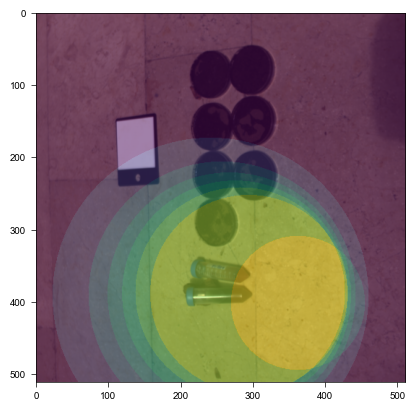

In [149]:
plt.imshow(rgb)
plt.imshow(masks, alpha=0.5)

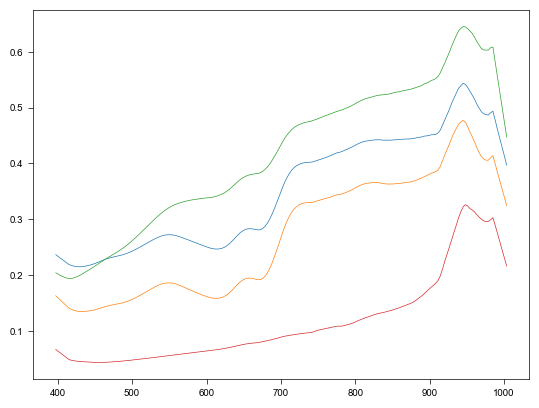

In [128]:
for i in range(len(mean_scores)):
    plt.plot(hsi_img.centers, mean_spec_ls[i])

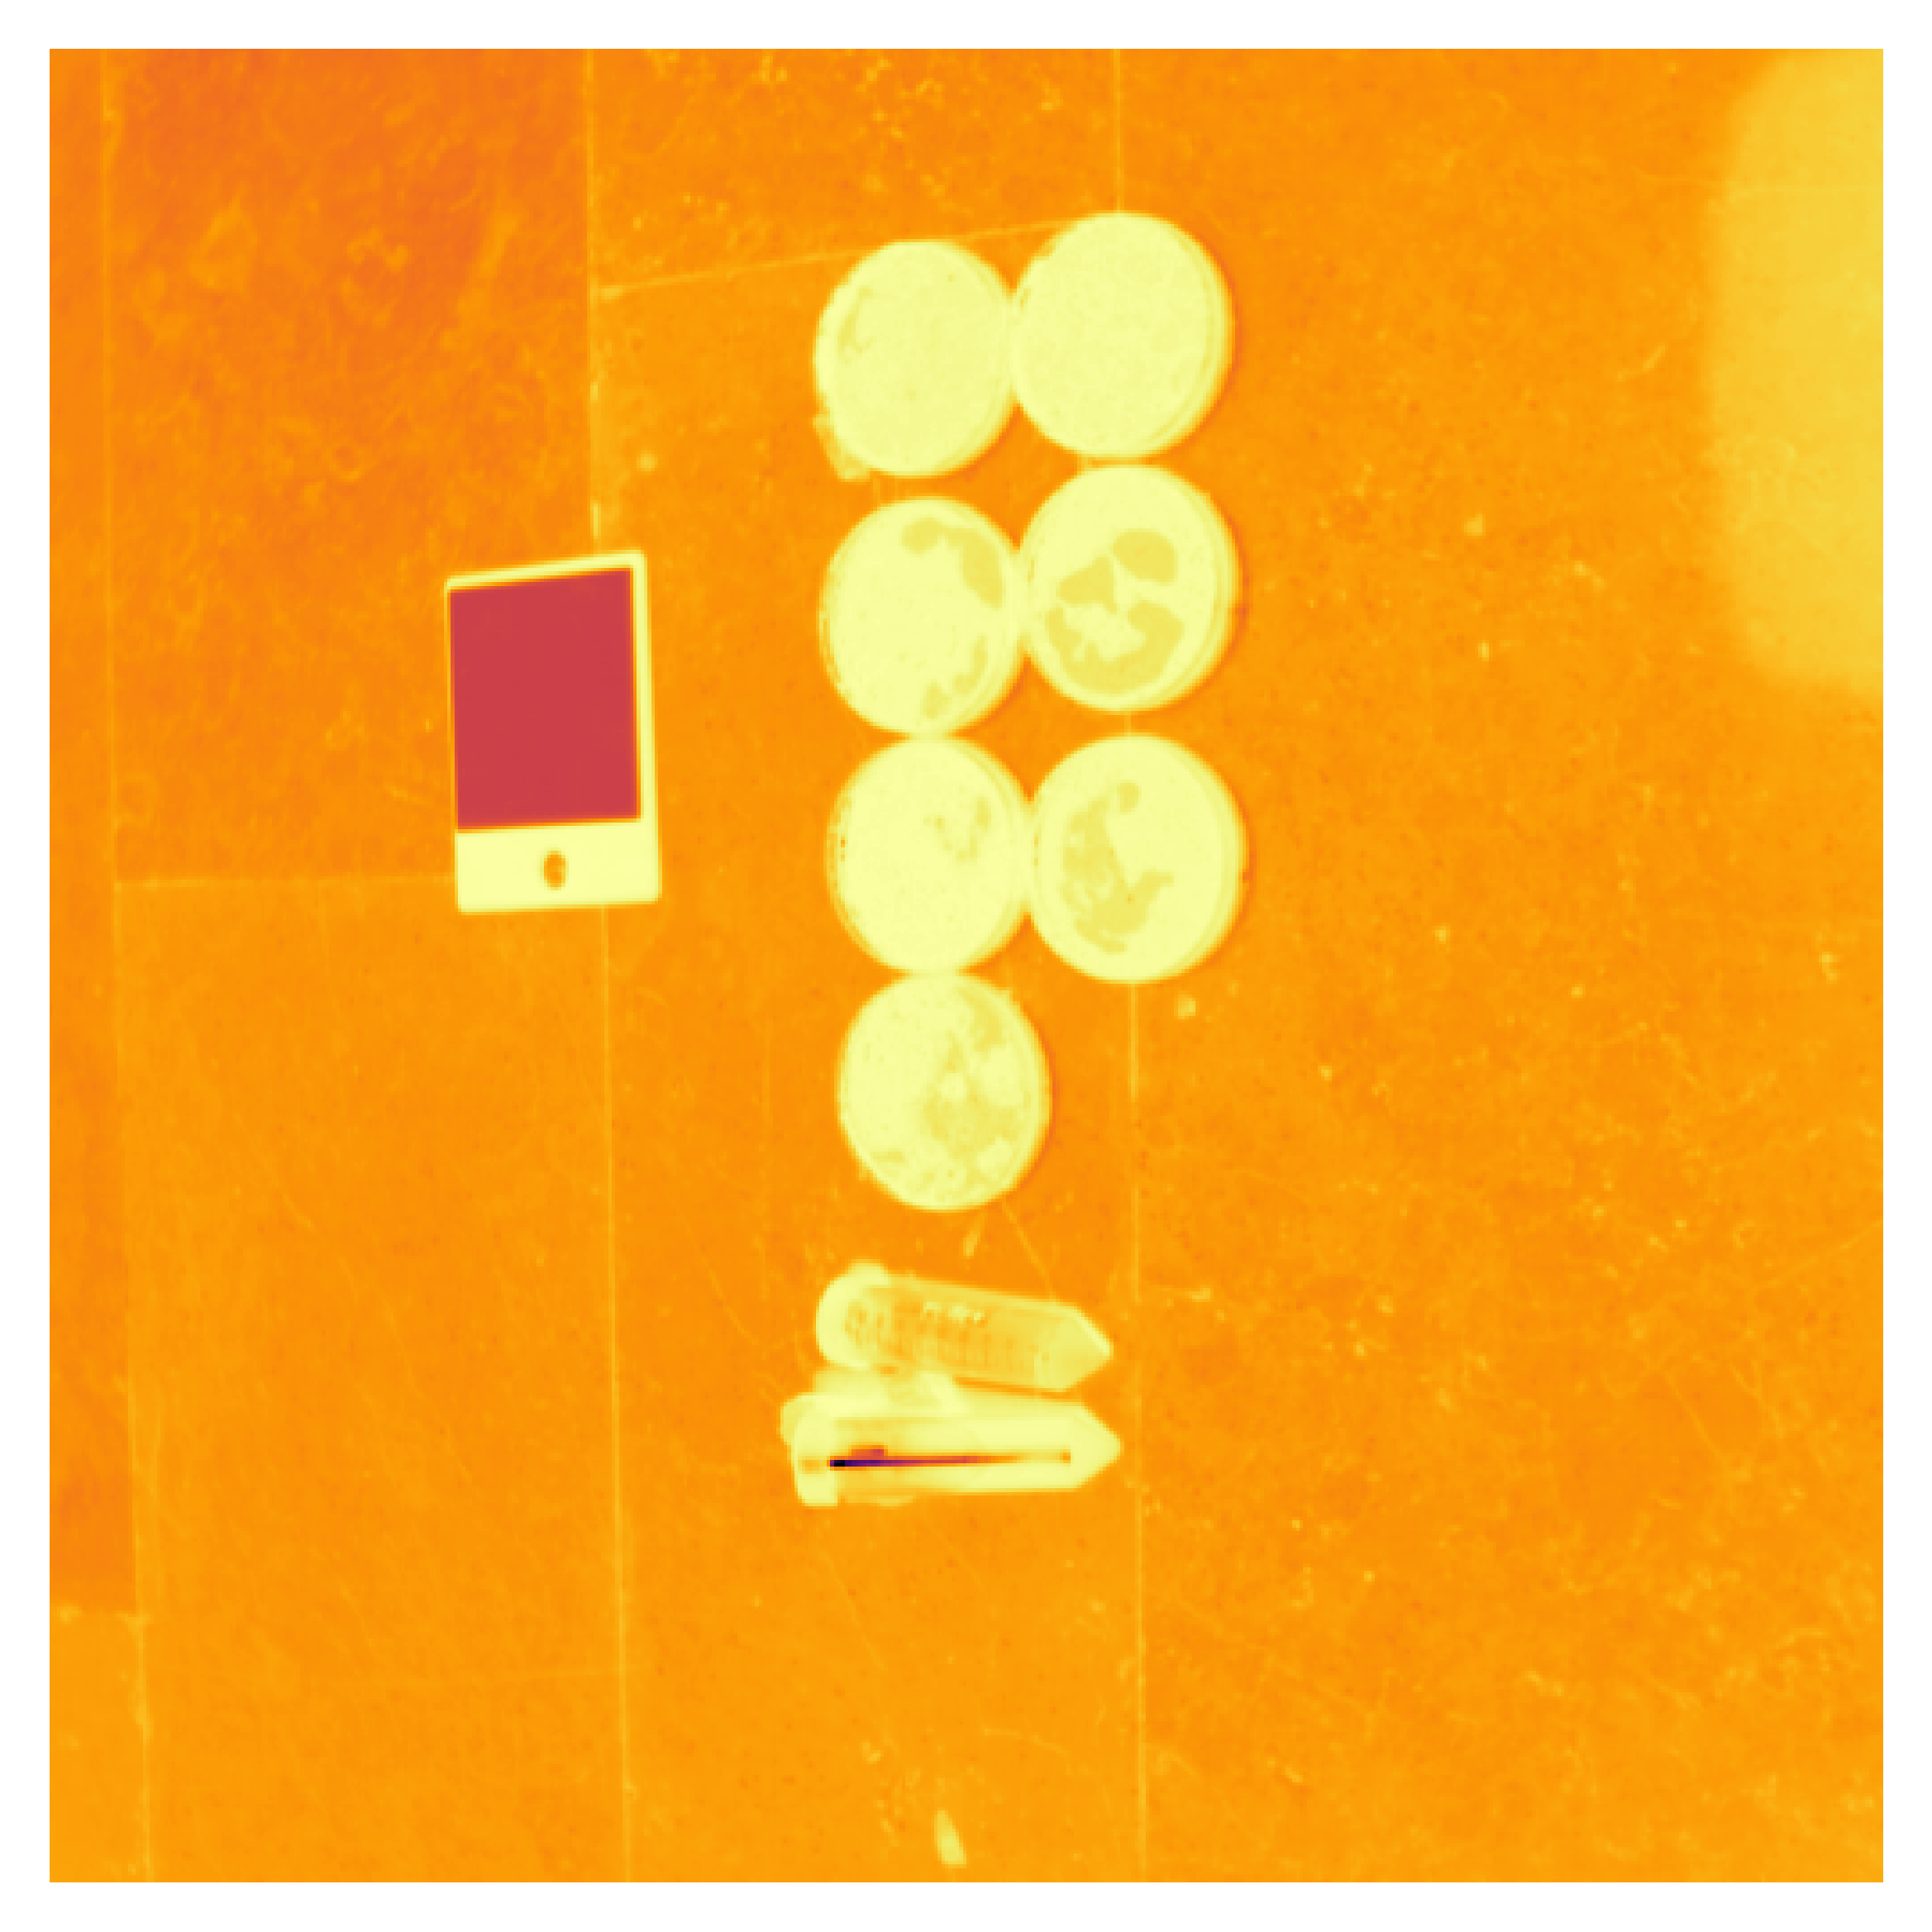

In [129]:
plt.figure(dpi=600)
plt.imshow(img[:,:,max_abs_idx], cmap='inferno_r')
plt.xticks([])
plt.yticks([])
plt.box()
plt.show()

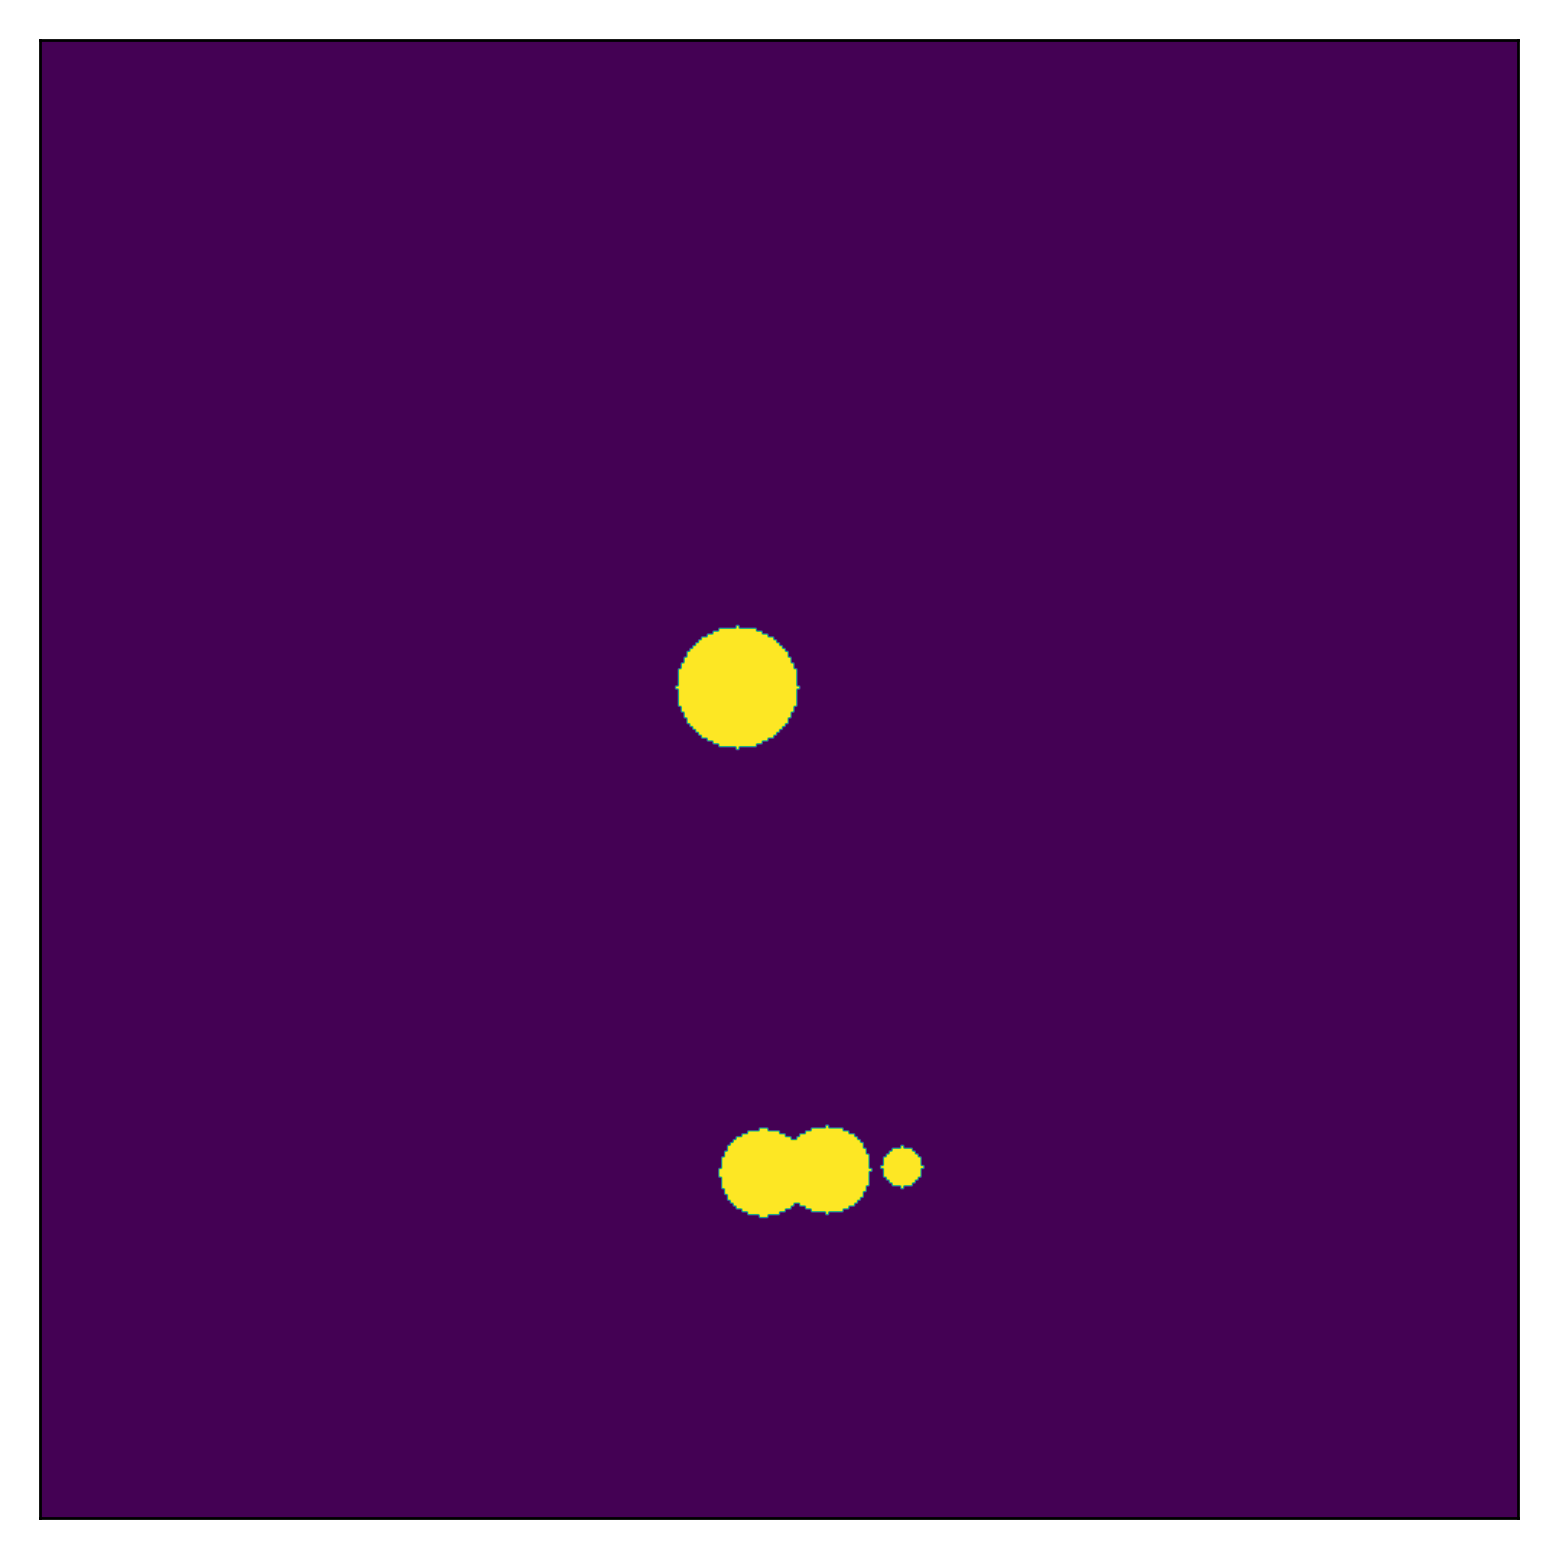

In [131]:
mask = masks
mask[mask>1] = 1
plt.figure(dpi=400)
plt.imshow(mask)
plt.xticks([])
plt.yticks([])
plt.show()

In [132]:
#label as "positive" the pixels within the rectangles of 10^1 and above? 

image_y = flatten_array(mask)

class 0.8556884384858606
abs 0.9242467714724276


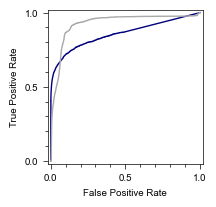

In [133]:
# import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

y_scores = flatten_array(scored_img.copy())
y_true = image_y.copy()
y_abs = 1-flatten_array(hsi_img.image[:,:,np.argmax(reference_spectrum.intensities)])
# y_abs = 1 - flatten_array(unnormed_img[:,:,np.argmax(reference_spectrum.intensities)]/ unnormed_img[:,:,np.argmax(reference_spectrum.intensities)+10])

y_true = y_true[~np.isnan(y_scores)]
y_abs = y_abs[~np.isnan(y_scores)]
y_scores = y_scores[~np.isnan(y_scores)]



# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
class_roc_auc = auc(fpr, tpr)


abs_fpr, abs_tpr, abs_thresholds = roc_curve(y_true, y_abs)
abs_roc_auc =  auc(abs_fpr, abs_tpr)

# Plotting the ROC curve
plt.figure(figsize=(2,2))
plt.plot(fpr, tpr, color='navy', lw=1, label='ROC curve (area = %0.2f)' % class_roc_auc)
print ('class', class_roc_auc)
plt.plot(abs_fpr, abs_tpr, color='darkgray', lw=1, label='ROC curve (area = %0.2f)' % abs_roc_auc)
print ('abs', abs_roc_auc)
# plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xticks([0,0.5,1])
plt.yticks([0,0.5,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.legend(loc="lower right")
plt.minorticks_on()
# plt.savefig(f'{savedir}/{date_str}_classification_ROC_curve.pdf')
plt.show()

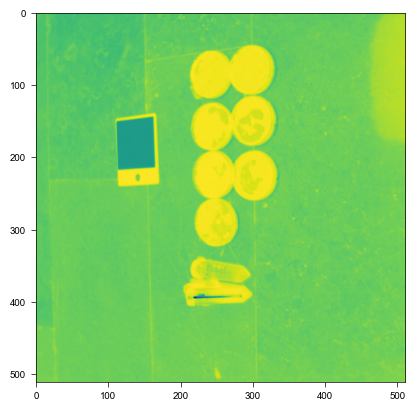

In [135]:
plt.imshow(1-hsi_img.image[:,:,np.argmax(reference_spectrum.intensities)])